In [1]:
# use niwrap3912 for conda environment: import ENIGMA toolbox for just getting the data
# paper reference for short and long distance but it is for vertex-level distance 
# --> https://journals.plos.org/ploscompbiol/article?id=10.1371/journal.pcbi.1000808

from enigmatoolbox.datasets import load_sc, load_fc
import matplotlib.pyplot as plt
import numpy as np
import os
import nibabel as nib
import yaspy

BASEPATH = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server'

#https://github.com/ThomasYeoLab/CBIG/blob/master/stable_projects/brain_parcellation/Schaefer2018_LocalGlobal/Parcellations/HCP/fslr32k/cifti/Schaefer2018_200Parcels_7Networks_order.dscalar.nii
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
#split atlas into left and right hemispheres for later use       
atlas_data_lh = atlas[:len(atlas)//2]
atlas_data_rh = atlas[len(atlas)//2:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0])+1
atlas_data_rh[atlas_data_rh <= 0] = 0
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path

yeo_networks = nib.load(atlas_path).header.get_axis(0)
yeo_network_data = yeo_networks.get_element(0)[1]

#each yeo_network_data[key] has ('17Networks_LH_VisCent_ExStr_1',...), save the third string after string split by '_'
yeo_network_names = []
yeo_network_colors = []
for i,key in enumerate(yeo_network_data):
    if i == 0:
        yeo_network_names.append(np.nan)
        yeo_network_colors.append((0,0,0,0))
        continue#skip the first key
# print(yeo_network_data[key][0])#network name
    network_parts = yeo_network_data[key][0].split('_')
    #print(network_parts)
    yeo_network_names.append(network_parts[2])  # Append the network name (VisCent)
    yeo_network_colors.append(yeo_network_data[key][1])



lh_surf = f'{BASEPATH}/HCP_S1200_Atlas_Z4_pkXDZ/S1200.L.white_MSMAll.32k_fs_LR.surf.gii'
rh_surf = f'{BASEPATH}/HCP_S1200_Atlas_Z4_pkXDZ/S1200.R.white_MSMAll.32k_fs_LR.surf.gii'



pixdim[1,2,3] should be non-zero; setting 0 dims to 1
pixdim[1,2,3] should be non-zero; setting 0 dims to 1


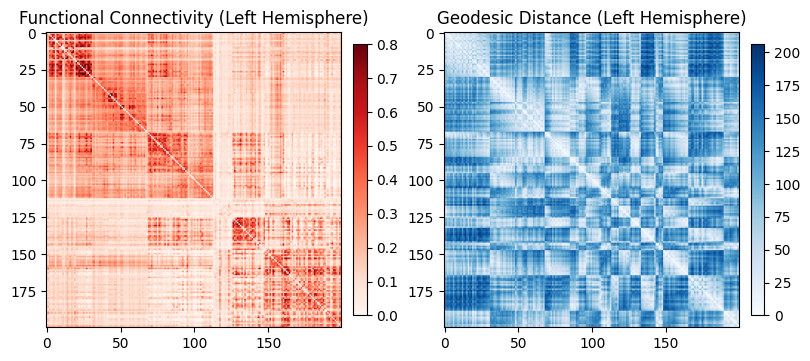

In [2]:

# use ENIGMA toolbox to load Schaefer 400 parcellation
fc_ctx, fc_ctx_labels, _, _ = load_fc('schaefer_400')
fc_ctx_lh = fc_ctx[0:200, 0:200]

# load geodesic distance matrix
basepath = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server/distance/geodesic_schaefer400'
filename = 'white_lh/gd_matrix.npy'
geodesic_distance_matrix = np.load(os.path.join(basepath, filename))

# Organize plots together as subplots
fig, axes = plt.subplots(1, 2, figsize=(8, 4), constrained_layout=True)

# Plot FC matrix (left panel)
im0 = axes[0].imshow(fc_ctx_lh, cmap='Reds', vmin=0, vmax=0.8)
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_title('Functional Connectivity (Left Hemisphere)')

# Plot Geodesic Distance matrix (right panel)
im1 = axes[1].imshow(geodesic_distance_matrix, cmap='Blues')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title('Geodesic Distance (Left Hemisphere)')

plt.show()


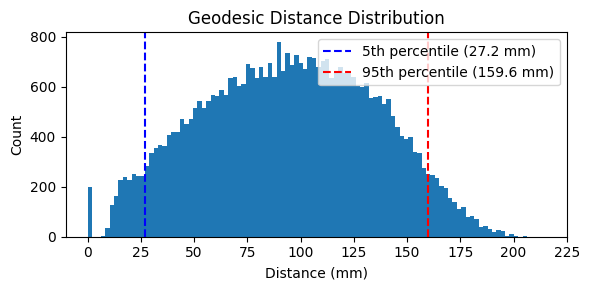

In [3]:
#thresholding
#Threshold for monkey was 12 and 20 mm for short and long distance, respectively. 
#Need to scale this by X amount. And based on some literatures monkey brain's AP length is about 73mm (Sedlitz et al., 2019) and
#human brain AP length was about 170 mm. So I will do simple scaling of ~170/70 which is about 2.5x.


# Use np.arange with stop=201 to include 200 mm in the thresholds
short_distance_thresholds = np.arange(10, 201, 10)
long_distance_thresholds = short_distance_thresholds

plt.figure(figsize=(6,3))
data = geodesic_distance_matrix.flatten()
plt.hist(data, bins=100)
plt.ylabel('Count')
plt.xlabel('Distance (mm)')
plt.title('Geodesic Distance Distribution')

# Calculate percentiles
lower_pct = np.percentile(data, 5)
upper_pct = np.percentile(data, 95)

# Show vertical lines at percentiles
plt.axvline(lower_pct, color='blue', linestyle='--', label=f'5th percentile ({lower_pct:.1f} mm)')
plt.axvline(upper_pct, color='red', linestyle='--', label=f'95th percentile ({upper_pct:.1f} mm)')

# Set x-axis ticks at every 25
min_dist = np.nanmin(geodesic_distance_matrix)
max_dist = np.nanmax(geodesic_distance_matrix)
tick_start = 25 * int(min_dist // 25)
tick_end = 25 * (int(max_dist // 25) + 1)
plt.xticks(np.arange(tick_start, tick_end + 1, 25))

plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Long Distance (> 10 mm)')

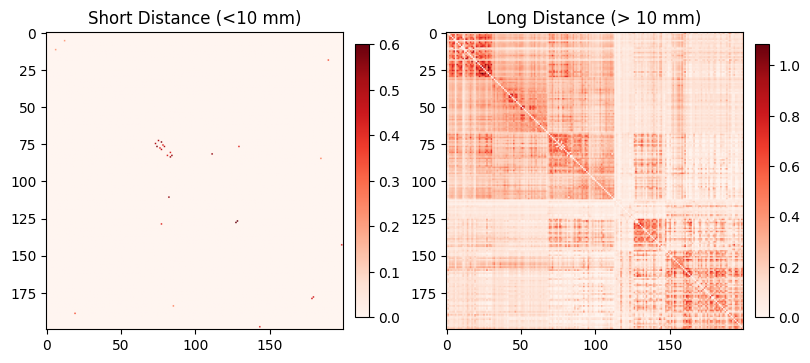

In [4]:
short_distance_threshold = short_distance_thresholds[0]
long_distance_threshold = long_distance_thresholds[0]
#create mask for short and long distance (for 2D geodesic_distance_matrix)
short_distance_mask = geodesic_distance_matrix < short_distance_threshold
long_distance_mask = geodesic_distance_matrix > long_distance_threshold

fc_lh_masked_short = np.array(fc_ctx_lh, copy=True)
fc_lh_masked_short[~short_distance_mask] = np.ma.masked

fc_lh_masked_long = np.array(fc_ctx_lh, copy=True)
fc_lh_masked_long[~long_distance_mask] = np.ma.masked

fig, axes = plt.subplots(1, 2, figsize=(8,4), constrained_layout=True)
im0 = axes[0].imshow(fc_lh_masked_short, cmap='Reds')
fig.colorbar(im0, ax=axes[0], fraction=0.046, pad=0.04)
axes[0].set_title(f'Short Distance (<{short_distance_threshold} mm)')

im1 = axes[1].imshow(fc_lh_masked_long, cmap='Reds')
fig.colorbar(im1, ax=axes[1], fraction=0.046, pad=0.04)
axes[1].set_title(f'Long Distance (> {long_distance_threshold} mm)')



In [5]:
#calculate gradients for the thresholded functional connectivity matrices
import os,sys
notebook_dir = os.getcwd()
sys.path.append(os.path.abspath(os.path.join(notebook_dir, '../092325_cortical_gradients')))
from gradient_utils import calculate_gradients_from_brainspace,align_gradients,create_hemisphere_plots
from brainspace.utils.parcellation import map_to_labels
from scipy.linalg import orthogonal_procrustes
from scipy.stats import spearmanr

N_components = 20
N_components_plot = 10
G_dimension_reduction = 'pca'
G_sparsity = 0 #set to zero so that it doesn't threshold the matrices that are already thresholded
G_kernel = 'normalized_angle'
DO_PLOT = True
cmap = 'jet'
mask_lh = atlas_data_lh != 0

for short_distance_threshold, long_distance_threshold in zip(short_distance_thresholds, long_distance_thresholds):

    short_distance_mask = geodesic_distance_matrix < short_distance_threshold
    long_distance_mask = geodesic_distance_matrix > long_distance_threshold

    fc_lh_masked_short = np.array(fc_ctx_lh, copy=True)
    fc_lh_masked_short[~short_distance_mask] = np.ma.masked

    fc_lh_masked_long = np.array(fc_ctx_lh, copy=True)
    fc_lh_masked_long[~long_distance_mask] = np.ma.masked

    gm_short_lh, grad_short_lh = calculate_gradients_from_brainspace(fc_lh_masked_short, np.nan, atlas_data_lh, mask_lh, N_components, 
                                                            g_dimension_reduction=G_dimension_reduction,g_sparsity=G_sparsity,g_kernel = G_kernel )
    gm_long_lh, grad_long_lh = calculate_gradients_from_brainspace(fc_lh_masked_long, np.nan, atlas_data_lh, mask_lh, N_components, 
                                                            g_dimension_reduction=G_dimension_reduction,g_sparsity=G_sparsity,g_kernel = G_kernel )

    #save them as npy files
    savepath = 'output'
    if not os.path.exists(savepath):
        os.makedirs(savepath)

    np.save(os.path.join(savepath, f'gm_and_grad_short_lh_{short_distance_threshold}mm.npy'), {'gm_short_lh': gm_short_lh, 'grad_short_lh': grad_short_lh}, allow_pickle=True)
    np.save(os.path.join(savepath, f'gm_and_grad_long_lh_{long_distance_threshold}mm.npy'), {'gm_long_lh': gm_long_lh, 'grad_long_lh': grad_long_lh}, allow_pickle=True)

    if DO_PLOT:
        # This doesn't align anything
        tmp_short_lh, R_short_lh = align_gradients(np.array(grad_short_lh).T, np.array(grad_long_lh).T, reflection=False, rotation=False)
        tmp_long_lh, R_long_lh = align_gradients(np.array(grad_long_lh).T, np.array(grad_long_lh).T, reflection=False, rotation=False)

        figspath = os.path.join('output', 'figures')
        if not os.path.exists(figspath):
            os.makedirs(figspath)

        # Plot short-distance gradients and save figure
        plotters_short_lh = create_hemisphere_plots({0: tmp_short_lh}, lh_surf, hemi='lh', N_components_plot=N_components_plot, color_ranges=[0.1]*N_components_plot, cmap=cmap)

        num_pcas = N_components_plot
        fig, axs = plt.subplots(2, num_pcas, figsize=(2*num_pcas, 3))
        for i in range(num_pcas):
            if i == 0:
                fig.suptitle(f"Short Distance (< {short_distance_threshold} mm)", fontsize=14, y=1.05)
            # Lateral view
            ax_lateral = axs[0, i] if num_pcas > 1 else axs[0]
            ax_lateral.imshow(plotters_short_lh[i][0])
            ax_lateral.set_title(f'Component {i+1}', fontsize=11)
            ax_lateral.axis('off')
            # Medial view
            ax_medial = axs[1, i] if num_pcas > 1 else axs[1]
            ax_medial.imshow(plotters_short_lh[i][1])
            ax_medial.axis('off')
        plt.tight_layout()
        short_fig_filename = os.path.join(figspath, f'short_distance_gradients_{short_distance_threshold}mm.png')
        plt.savefig(short_fig_filename, bbox_inches='tight', dpi=150)
        plt.close(fig)
        del plotters_short_lh  # clear plotters after saving figure

        # Plot long-distance gradients and save figure
        plotters_long_lh = create_hemisphere_plots({0: tmp_long_lh}, lh_surf, hemi='lh', N_components_plot=N_components_plot, color_ranges=[0.1]*N_components_plot, cmap=cmap)

        fig, axs = plt.subplots(2, num_pcas, figsize=(2*num_pcas, 3))
        for i in range(num_pcas):
            if i == 0:
                fig.suptitle(f"Long Distance (> {long_distance_threshold} mm)", fontsize=14, y=1.05)
            ax_lateral = axs[0, i] if num_pcas > 1 else axs[0]
            ax_lateral.imshow(plotters_long_lh[i][0])
            ax_lateral.set_title(f'Component {i+1}', fontsize=11)
            ax_lateral.axis('off')
            ax_medial = axs[1, i] if num_pcas > 1 else axs[1]
            ax_medial.imshow(plotters_long_lh[i][1])
            ax_medial.axis('off')
        plt.tight_layout()
        long_fig_filename = os.path.join(figspath, f'long_distance_gradients_{long_distance_threshold}mm.png')
        plt.savefig(long_fig_filename, bbox_inches='tight', dpi=150)
        plt.close(fig)
        del plotters_long_lh  # clear plotters after saving figure

no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)
no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)
no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)
no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)
no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)
no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


no mask
no mask
X (32492, 20)
Y (32492, 20)
X (32492, 20)
Y (32492, 20)


Context leak detected, msgtracer returned -1


In [6]:
import matplotlib.pyplot as plt
import numpy as np
tmp = np.load('/Users/dennis.jungchildmind.org/Downloads/batch_009_sum.npy')
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
#ATLAS


In [7]:
import nibabel as nib
import numpy as np
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
atlas = nib.load(atlas_path).get_fdata()[0].astype(int)
#split atlas into left and right hemispheres for later use       
atlas_data_lh = atlas[:len(atlas)//2]
atlas_data_rh = atlas[len(atlas)//2:]
atlas_data_rh = atlas_data_rh - np.min(atlas_data_rh[atlas_data_rh != 0])+1
atlas_data_rh[atlas_data_rh <= 0] = 0
num_parcels = int(atlas_path.split('_')[1].split('Parcels')[0])  # Extract number of parcels from atlas path



pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [ ]:
import nibabel as nib
BASEPATH = '/Users/dennis.jungchildmind.org/Desktop/To-be-uploaded-to-CMI-server'
atlas_path = f'{BASEPATH}/parcellation/Schaefer/Schaefer2018_400Parcels_7Networks_order.dlabel.nii'
tmp = nib.load(atlas_path).get_fdata()[0].astype(int)


pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [16]:
#mask the brain area (from upto index 29696, which is the LEFT hemisphere)
ba  = nib.load(atlas_path).header.get_axis(1)
mask = np.zeros(32492).astype(bool)
mask[ba.vertex[:29696]] = 1#
#atlas_data_lh_ = atlas_data_lh.copy()
atlas = atlas_data_lh[mask]
atlas_data_lh_ = atlas_data_lh.copy()
# remove zero values from the data
atlas_data_lh_ = atlas_data_lh_[mask]
print(atlas_data_lh_.shape)

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


(29696,)


In [ ]:
#average for each parcel in the functional connectivity matrix
import numpy as np
datapath = '/Users/dennis.jungchildmind.org/Downloads/batch_009_sum.npy'
try:
    data = np.load(datapath)
except Exception as e:
    print(f"Failed to open {datapath} as a .npz file: {repr(e)}")
    # Try opening as regular .npy or print file type
    import os
    print("File size (MB):", os.path.getsize(datapath)/1024/1024)
    with open(datapath, "rb") as f:
        magic = f.read(8)
    print("File magic header bytes:", magic)
    raise
print(data.shape)

#average for each parcel in the functional connectivity matrix
# Parcellate and average data according to atlas_data_lh_
# Average a 2D matrix (data) over parcels defined in atlas_data_lh_
unique_parcels = np.unique(atlas_data_lh_)
unique_parcels = unique_parcels[unique_parcels != 0]  # Exclude background/zero


(29696, 29696)
